In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts

In [2]:
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']

# RTS index

## Reading files

In [6]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [7]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

## Setting parameters & data

In [8]:
rescale_factor = 100
start_date = '2020-01-01'

input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

In [9]:
n = input_data.shape[0]

In [10]:
n

452

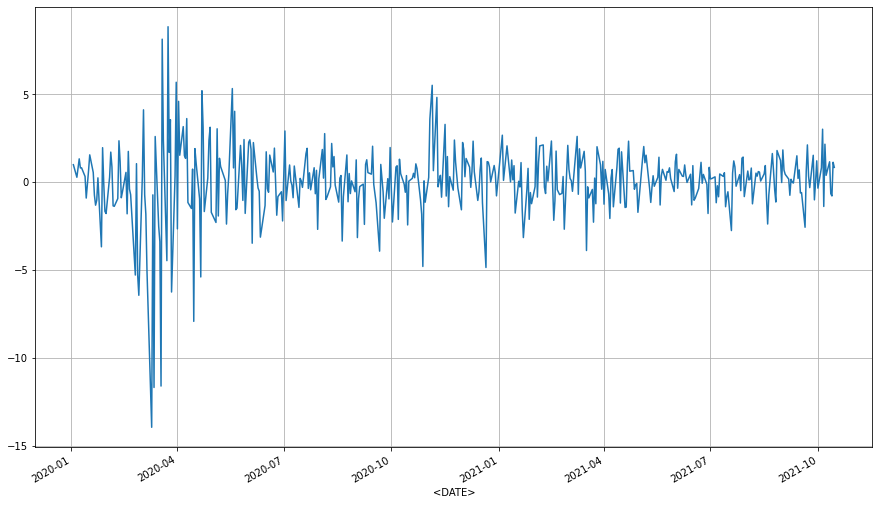

In [11]:
input_data.plot(figsize=(15, 9))

plt.grid()
plt.show()

In [12]:
input_data.describe()

count    452.000000
mean       0.044213
std        2.065685
min      -13.948614
25%       -0.832806
50%        0.209539
75%        0.996702
max        8.825149
Name: log return, dtype: float64

In [13]:
days_of_week = pd.Series(input_data.index.dayofweek, index=input_data.index, name='day of week').copy()

### train & test split 

In [14]:
n_train = 100  # 2000
n_test = n - n_train

In [15]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:].copy()

# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

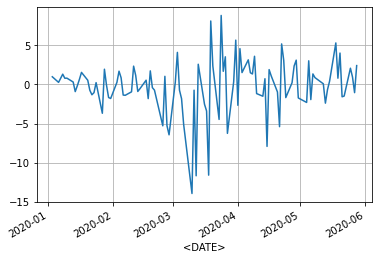

In [16]:
train.plot()

plt.grid()
plt.show()

In [17]:
train.describe()

count    100.000000
mean      -0.221020
std        3.555565
min      -13.948614
25%       -1.526033
50%        0.267737
75%        1.575485
max        8.825149
Name: log return, dtype: float64

### Setting consequent meta parameters

In [18]:
# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

In [19]:
train_sample_std

3.55556536608784

In [20]:
first_h

array([12.64204507])

#### Using classic GARCH to get initial parameters values

In [21]:
garch_mean = 'Zero'
garch_dist = 'normal'

garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 399.94786263680555
Iteration:      2,   Func. Count:     12,   Neg. LLF: 261.3594665086619
Iteration:      3,   Func. Count:     17,   Neg. LLF: 268.3983066422309
Iteration:      4,   Func. Count:     22,   Neg. LLF: 251.10666216238394
Iteration:      5,   Func. Count:     27,   Neg. LLF: 250.54453312288277
Iteration:      6,   Func. Count:     31,   Neg. LLF: 266.8929038107542
Iteration:      7,   Func. Count:     37,   Neg. LLF: 250.53845600824525
Iteration:      8,   Func. Count:     41,   Neg. LLF: 250.53844711694992
Iteration:      9,   Func. Count:     45,   Neg. LLF: 250.5384291777395
Optimization terminated successfully    (Exit mode 0)
            Current function value: 250.53842917791982
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9


In [22]:
garch_fitted.params

omega       0.344119
alpha[1]    0.188090
beta[1]     0.806914
Name: params, dtype: float64

In [23]:
alpha_0_ini_vanilla = garch_fitted.params.iloc[0]
alpha_ini_vanilla = garch_fitted.params.iloc[1:(q + 1)].values
beta_ini_vanilla = garch_fitted.params.iloc[(q + 1):].values

In [24]:
consequent_params_ini_vanilla = {'alpha_0': alpha_0_ini_vanilla, 'alpha': alpha_ini_vanilla, 'beta': beta_ini_vanilla}

#### Setting dict w/ all consequent meta parameters

In [25]:
consequent_parameters = {'p': p, 'q': q, 'first_h': first_h}

##### `parameters_ini` and `bounds` not yet set!

## Modeling

### 2 clusters

#### setting clusterization (antecedent) parameters

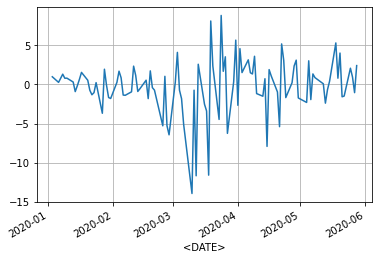

In [26]:
train.plot()

plt.grid()
plt.show()

In [27]:
clusterization_method = 'gaussian'

n_clusters = 3

# mu = 0
# sigma = 1

centers = [0, -10, 5]  # np.array([[mu] * n])
variances = [4, 2, 2]  # np.array([np.diag([sigma] * n, k=0)])

clusterization_parameters = {'centers': centers, 'variances': variances, 'n_clusters': n_clusters}

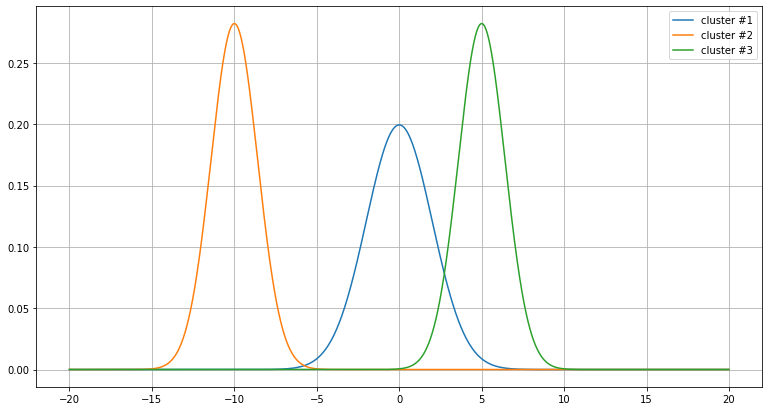

In [28]:
plt.figure(figsize=(13, 7))

for i in range(n_clusters):
    _range = np.arange(-20, 20, .01)
    _data = sts.norm(centers[i], variances[i] ** .5).pdf(_range)
    
    plt.plot(_range, _data, label=f'cluster #{i + 1}')
   
plt.legend()
plt.grid()
plt.show()

#### setting `parameters_ini` in consequent

In [29]:
alpha_0_ini = np.array([alpha_0_ini_vanilla] * n_clusters)
alpha_ini = np.array([alpha_ini_vanilla] * n_clusters).T
beta_ini = np.array([beta_ini_vanilla] * n_clusters).T

parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

consequent_parameters['parameters_ini'] = parameters_ini

In [30]:
parameters_ini

{'alpha_0': array([0.34411863, 0.34411863, 0.34411863]),
 'alpha': array([[0.18808981, 0.18808981, 0.18808981]]),
 'beta': array([[0.80691412, 0.80691412, 0.80691412]])}

#### setting consequent parameters constraints (passed to LS)

In [31]:
lower_bounds = [0] * ((1 + p + q) * n_clusters)
upper_bounds = [+np.inf] * n_clusters + [1] * ((p + q) * n_clusters)
bounds = (lower_bounds, upper_bounds)

consequent_parameters['bounds'] = bounds

#### creating model instance

In [31]:
# logging.basicConfig(level=logging.DEBUG)

In [32]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=consequent_parameters,
                           data_to_cluster='train')

##### fitting

In [ ]:
%%time

fvm.fit()

##### testing

In [34]:
n_test_small = 30

test_small = test.iloc[:n_test_small].copy()
input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_small = data_to_cluster_test.iloc[:n_test_small].copy()

In [ ]:
%%time

fvm.feed_daily_data(test_small, data_to_cluster=None)

In [ ]:
len(fvm._hist_output)

In [ ]:
fvm.hist_output.shape

In [ ]:
# (fvm.rules_outputs_hist[0] == fvm.rules_outputs_hist[1]).all()

In [ ]:
fvm.clusters_parameters_hist

#### Plots

In [ ]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test_small, reindex=False).variance.iloc[0].values

In [ ]:
simple_garch_forecasts

In [ ]:
plt.plot(fvm.h[:-1] ** .5, label='forecast')
plt.plot(input_cut.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(fvm.h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvm.hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvm.hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvm.hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

#### Errors

##### my model

In [ ]:
mean_squared_error(fvm.hist_output, test_small ** 2, squared=True)

In [ ]:
mean_squared_error(fvm.hist_output, test_small ** 2, squared=False)

In [ ]:
mean_absolute_percentage_error(fvm.hist_output, test_small ** 2)

##### GARCH (no retraining)

In [ ]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=True)

In [ ]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=False)

In [ ]:
mean_absolute_percentage_error(simple_garch_forecasts, test_small ** 2)

# Trying to find the best antecedent parameters

In [36]:
clusterization_parameters

{'centers': [0, -10, 5], 'variances': [4, 2, 2], 'n_clusters': 3}

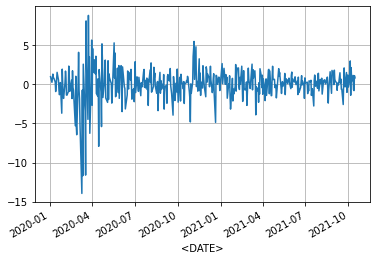

In [43]:
input_data.plot()

plt.grid()
plt.show()

In [44]:
clusterization_method = 'gaussian'

n_clusters = 4

# mu = 0
# sigma = 1

centers = [-10, -2, 3, 4]  # np.array([[mu] * n])
variances = [2, 2, 2, 2]  # np.array([np.diag([sigma] * n, k=0)])

antecedent_params_start = {'centers': centers, 'variances': variances, 'n_clusters': n_clusters}

In [32]:
antecedent_params_set = [clusterization_parameters]

In [ ]:
result = fit_antecedent_params(train, test,
                               consequent_metaparams=consequent_parameters,
                               consequent_params_ini=consequent_params_ini_vanilla,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_method,
                               local_method=local_method,
                               data_to_cluster_train='train', data_to_cluster_test=None)

In [54]:
result

{'fvms': [<model.FuzzyVolatilityModel at 0x7f8cf7d82280>],
 'mses': [21.25746191714223955],
 'mapes': [0.6890371904013534846]}

In [59]:
result['mses']

[21.25746191714223955]